In [1]:
!pip install --quiet -U langchain langchain_openai langgraph langchainhub langchain_experimental


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


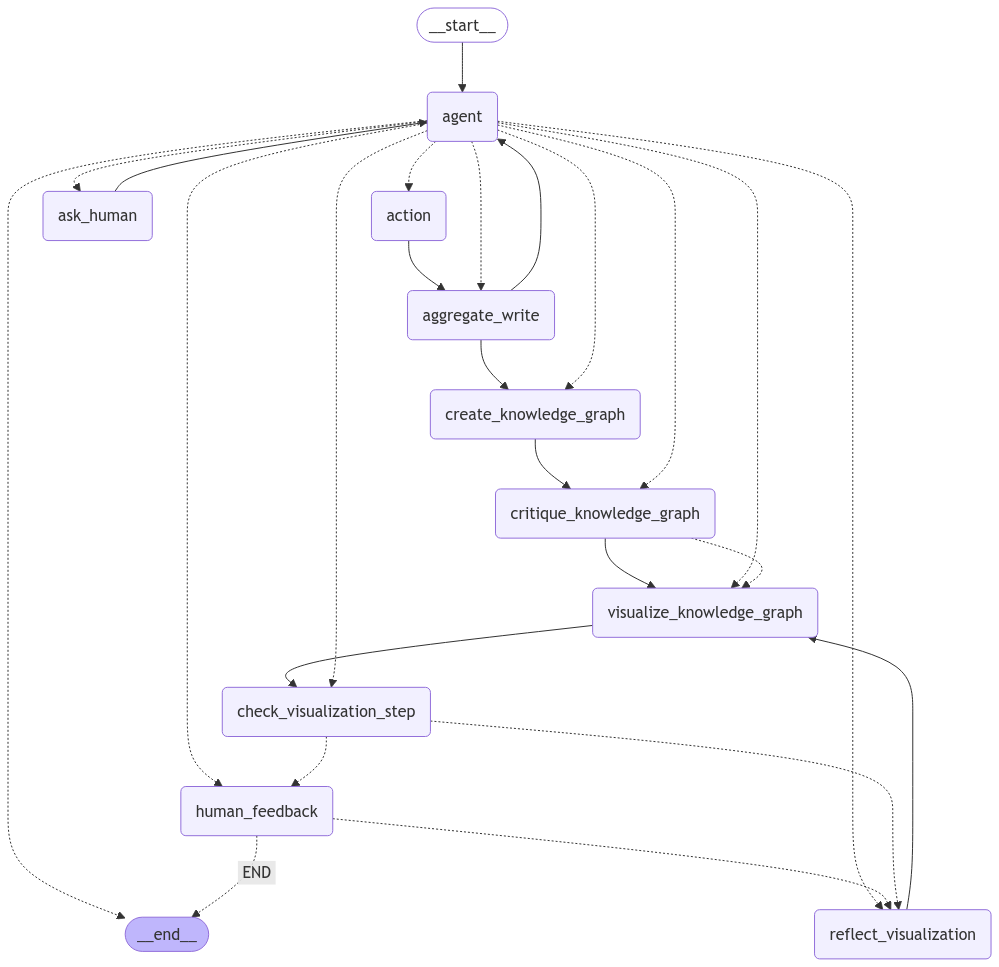

In [2]:
#####-----------------****** IMPORTS ******-----------------#####
import sys
import getpass
import os
import logging
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, List, Dict, Any, Sequence
import operator
import json
from langgraph.graph import StateGraph, START, END
from langchain.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.agents import AgentAction
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import END, StateGraph
from langgraph.graph import MessagesState, START
from langgraph.types import Command, interrupt

from pydantic import BaseModel

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

#####-----------------****** ENVIRONMENT SETUP ******-----------------#####

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph_01"


from langchain_openai import ChatOpenAI

# Define the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)

####-----------------****** TOOLS ******-----------------#####

@tool("symbol_detector", return_direct=True)
def extract_symbols_t(input:str) -> List[Dict[str, Any]]:
    """TOOL: Calls the CV Function to extract the symbols in the P&ID image"""
    # NOTE: This currently points to the json file, adjust later
    with open("/Users/hivamoh/Desktop/IntuigenceAI/2/2_detected_symbols.json", 'r') as file:
        data = json.load(file)
    return data["detections"]

@tool("text_detector", return_direct=True)
def extract_texts_t(input:str) -> List[Dict[str, Any]]:
    """TOOL: Calls the CV Function to extract the text in the P&ID image"""
    # NOTE: This currently points to the json file, adjust later
    with open("/Users/hivamoh/Desktop/IntuigenceAI/2/2_detected_texts.json", 'r') as file:
        data = json.load(file)
    return data["detections"]

@tool("line_detector", return_direct=True)
def extract_lines_t(input:str) -> List[Dict[str, Any]]:
    """TOOL: Calls the CV Function to extract the lines in the P&ID image"""
    # NOTE: This currently points to the json file, adjust later
    with open("/Users/hivamoh/Desktop/IntuigenceAI/2/2_detected_lines.json", 'r') as file:
        data = json.load(file)
    return data["detections"]

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@tool("document_writer", return_direct=True)
def write_document_t(processed_data: Dict[str, Any]) -> str:
    """
    TOOL: Writes the processed symbols, texts, and lines into a document.
    """
    try:
        document_path = "/Users/hivamoh/Desktop/IntuigenceAI/2/processed_p&ID_document.json"
        with open(document_path, 'w') as doc_file:
            json.dump(processed_data, doc_file, indent=4)
        logger.info(f"Document written successfully to {document_path}")
        return f"Document written successfully to {document_path}"
    except Exception as e:
        logger.error(f"Failed to write document: {e}")
        return f"Failed to write document: {e}"



#####-----------------****** REFLECTION AND CRITIQUE TOOLS ******-----------------#####
# Separate model for reflection, critique and check to ensure independence
reflection_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
critique_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
check_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

@tool("symbol_reflector", return_direct=True)
def reflect_symbols(output_json: str) -> str:
    """
    REFLECTION TOOL: Evaluates the quality of the symbols extracted.
    """
    prompt = f"Evaluate the following extracted symbols for accuracy and completeness:\n{output_json}\nProvide feedback."
    reflection = reflection_model.invoke(prompt)
    return reflection

@tool("text_reflector", return_direct=True)
def reflect_texts(output_json: str) -> str:
    """
    REFLECTION TOOL: Evaluates the quality of the texts extracted.
    """
    prompt = f"Evaluate the following extracted texts for accuracy and completeness:\n{output_json}\nProvide feedback."
    reflection = reflection_model.invoke(prompt)
    return reflection

@tool("line_reflector", return_direct=True)
def reflect_lines(output_json: str) -> str:
    """
    REFLECTION TOOL: Evaluates the quality of the lines extracted.
    """
    prompt = f"Evaluate the following extracted lines for accuracy and completeness:\n{output_json}\nProvide feedback."
    reflection = reflection_model.invoke(prompt)
    return reflection

@tool("document_reflector", return_direct=True)
def reflect_document(output: str) -> str:
    """
    REFLECTION TOOL: Evaluates the success of the document writing process.
    """
    prompt = f"Evaluate the following document writing output for success and correctness:\n{output}\nProvide feedback."
    reflection = reflection_model.invoke(prompt)
    return reflection

@tool("knowledge_graph_reflector", return_direct=True)
def critique_knowledge_graph(output_json: str) -> str:
    """
    CRITIQUE TOOL: Evaluates the quality of the created knowledge graph.
    """
    prompt = (
        f"Evaluate the following knowledge graph for accuracy, completeness, and proper structuring:\n{output_json}\nProvide detailed feedback and suggestions for improvements if necessary. Critique the knowledge graph that is provided and suggest improvements and recommendations and identify if there's anything missing or incorrect. Provide detailed recommendations, including requests for reprocessing the data and re analyzing the inputs."
    )
    critique = critique_model.invoke(prompt)
    return critique

@tool("visualization_reflector", return_direct=True)
def reflect_visualization(state) -> str:
    """
    REFLECTION TOOL: Provides feedback based on the visualization check results.
    """
    check_result = state.get("check_result", "")
    prompt = (
        f"Based on the following visualization check results, identify issues and suggest improvements:\n{check_result}\n"
        "Provide detailed feedback and recommendations."
    )
    reflection = reflection_model.invoke(prompt)
    return reflection

@tool("visualization_checker", return_direct=True)
def check_visualization(image_path: str) -> str:
    """
    CHECK TOOL: Assesses the quality of the knowledge graph visualization.
    """
    prompt = (
        f"Assess the quality of the knowledge graph visualization located at {image_path}. "
        "Is the visualization clear, accurate, and effectively representing the knowledge graph? "
        "Provide a concise assessment."
    )
    check_result = check_model.invoke(prompt)
    return check_result


#####-----------------****** GRAPH AND STATE DEFINITION ******-----------------#####
# Define Tools 
main_tools = [extract_symbols_t, extract_texts_t, extract_lines_t, write_document_t]

# Initialize ToolNode with main tools only
tool_node = ToolNode(main_tools)


# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""
    question: str

# Bind the tools to the model
model = model.bind_tools(main_tools + [AskHuman])


# Function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
  
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"


# Function to aggregate extracted data and trigger document writing
# NOTE: This includes our reflection logic as well 
def aggregate_and_write(state):
    state['p_and_id_image_path'] = "/Users/hivamoh/Desktop/IntuigenceAI/2/2.jpg"
    image_path = state["original_image_path"] 
    
    # Extract the latest detections
    symbols = extract_symbols_t(image_path)
    symbols_json = json.dumps(symbols, indent=2)
    symbol_reflection = reflect_symbols(symbols_json)
    logger.info(f"Symbol Reflection: {symbol_reflection}")

    texts = extract_texts_t(image_path)
    texts_json = json.dumps(texts, indent=2)
    text_reflection = reflect_texts(texts_json)
    logger.info(f"Text Reflection: {text_reflection}")

    lines = extract_lines_t(image_path)
    lines_json = json.dumps(lines, indent=2)
    line_reflection = reflect_lines(lines_json)
    logger.info(f"Line Reflection: {line_reflection}")

    # Aggregate the data
    processed_data = {
        "symbols": symbols,
        "texts": texts,
        "lines": lines
    }

    wrapped_processed_data = {"processed_data": processed_data}

    # # Write to document
    write_response = write_document_t(wrapped_processed_data)
    document_reflection = reflect_document(write_response)
    logger.info(f"Document Reflection: {document_reflection}")

    
    # Create the knowledge graph
    knowledge_graph = create_knowledge_graph(processed_data)
    knowledge_graph_json = json.dumps(knowledge_graph, indent=2)
    logger.info(f"Knowledge Graph Created: {knowledge_graph_json}")
    
    return {"messages": [HumanMessage(content=write_response)]}



def create_knowledge_graph(processed_data: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Takes the data and construct a knowledge graph of the P&ID using data from the text, line and symbol detectors"""
    # NOTE: This currently points to the json file, adjust later
    with open("/Users/hivamoh/Desktop/IntuigenceAI/2/2_graph_network.json", 'r') as file:
        data = json.load(file)
    return data

def visualize_knowledge_graph(processed_data: Dict[str, Any]) -> Dict[str, Any]:
    """Takes the knowledge graph and visualizes it"""
    # NOTE: This currently points to the json file, adjust later
    image = "/Users/hivamoh/Desktop/IntuigenceAI/2/2_graph_network_overlay.jpg"
    return  {"image_path": image}

#####-----------------****** GRAPH NODES ******-----------------#####

# Function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


# Node to ask the human for the path
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    location = input("What is the p&id path: ")
    tool_message = [{
        "tool_call_id": tool_call_id,
        "role": "tool",  # Corrected key
        "content": location
    }]
    return {"messages": tool_message}


# Node for reflecting on the knowledge graph
def critique_knowledge_graph_step(state):
    with open("/Users/hivamoh/Desktop/IntuigenceAI/2/2_aggregated_detections.json", 'r') as file:
        knowledge_graph_json = json.load(file)
    knowledge_graph_critique = critique_knowledge_graph(f"{knowledge_graph_json["detailed_results"]}")
    logger.info(f"Knowledge Graph Critique: {knowledge_graph_critique}")
    if "issue" in knowledge_graph_critique.content.lower() or "improve" in knowledge_graph_critique.content.lower():
        logger.warning("Issues detected in the Knowledge Graph. Initiating corrective actions.")
        # Set a flag to indicate corrective actions are needed
        return {"needs_correction": True}
    else:
        logger.info("Knowledge Graph is satisfactory.")
        # Set a flag to indicate the process is finished
        return {"finished": True}


def check_visualization_step(state):
    """
    Hardcoded FOR NOW CHECK TOOL: Assesses the quality of the knowledge graph visualization.
    Always returns that the visualization is satisfactory.
    """
    logger.info("Hardcoded: Visualization is satisfactory.")
    return {"proceed_visualization": True}


def get_human_feedback(state):
    """
    Prompt the user to provide feedback on the final knowledge graph.

    Args:
        state (PidState): The current state of the workflow.

    Returns:
        PidState: The updated state with user feedback.
    """
    
    user_input = input("Is the final knowledge graph satisfactory? (yes/no): ").strip().lower()
    if user_input in ['yes', 'y', 'no', 'n']:
        print(f"User Feedback: {user_input}")
        return {"user_feedback": user_input, "finished": True}  # Add termination flag
    else:
        print("Invalid input. Please respond with 'yes' or 'no'.")
        return get_human_feedback(state)


# Node to end the visualization process if no issues
def end_visualization(state):
    logger.info("Visualization is satisfactory. Proceeding to the next steps.")
    return {"finished": True}


class PIDState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    original_image_path: Annotated[str, operator.add]
#####-----------------****** GRAPH DEFINITION ******-----------------#####
# Define a new graph
workflow = StateGraph(PIDState)

# Define the nodes 
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)
workflow.add_node("aggregate_write", aggregate_and_write)
workflow.add_node("create_knowledge_graph", create_knowledge_graph)  
workflow.add_node("visualize_knowledge_graph", visualize_knowledge_graph) 
workflow.add_node("check_visualization_step", check_visualization_step)
workflow.add_node("critique_knowledge_graph", critique_knowledge_graph_step)
workflow.add_node("reflect_visualization", reflect_visualization)
workflow.add_node("human_feedback", get_human_feedback) 


# Define the edges 
workflow.add_edge(START, "agent")
workflow.add_edge("visualize_knowledge_graph", "check_visualization_step")
workflow.add_edge("create_knowledge_graph", "critique_knowledge_graph")
workflow.add_edge("ask_human", "agent")
workflow.add_edge("action", "aggregate_write")
workflow.add_edge("aggregate_write", "agent")
workflow.add_edge("critique_knowledge_graph", "visualize_knowledge_graph")
workflow.add_edge("aggregate_write", "create_knowledge_graph")
workflow.add_edge("reflect_visualization", "visualize_knowledge_graph")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_conditional_edges(
    "critique_knowledge_graph",
    lambda state: "visualize_knowledge_graph" if state.get("needs_correction") else  "visualize_knowledge_graph",
    {"visualize_knowledge_graph": "visualize_knowledge_graph", "visualize_knowledge_graph": "visualize_knowledge_graph"}
)

# Define conditional edges based on user_feedback
workflow.add_conditional_edges(
    "human_feedback",
    lambda state: "END" if state.get("user_feedback") in ['yes', 'y'] else "reflect_visualization",
    {
        "END": END,
        "reflect_visualization": "reflect_visualization"
    }
)

# Conditional edges based on the hardcoded check result
workflow.add_conditional_edges(
    "check_visualization_step",
    lambda state: "human_feedback" if state.get("proceed_visualization") else "reflect_visualization",
    {
        "human_feedback": "human_feedback",
        "reflect_visualization": "reflect_visualization"  
    }
)

# Set up memory
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Compile it!
app = workflow.compile(checkpointer=memory)

### For graph visualization
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

